## 신용카드 사용자 연체 예측

- 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측하는 알고리즘

## import package

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

## Data Load

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [4]:
train.shape

(26457, 20)

In [5]:
train.dtypes

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

- index         : key
- gender        : (obj)성별
- car           : (obj)차 소유여부
- reality       : (obj)
- child_num     : (int)자녀 수 
- income_total  : (int)수입
- income_type   : (obj)수입타입
- edu_type      : (obj)학벌
- family_type   : (obj)가족타입
- house_type    : (obj)집타입
- DAYS_BIRTH    : (int)태어난날짜
- DAYS_EMPLOYED : (int)취직날짜
- FLAG_MOBIL    : (obj)모바일폰 보유여부
- work_phone    : (obj)일하는 폰을 가졌는지? 여부?
- phone         : (obj)전화기 소유 여부??
- email         : (obj)이메일 소유 여부
- occyp_type    : (obj)직업코드(얘만 결측치 존재)
- family_size   : (int)가족인원 수
- begin_month   : (int)시작한 월수
- credit        : (label) 신용등급

In [6]:
# column 다 소문자로
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## 간단한 EDA

In [7]:
train.describe()

,index,child_num,income_total,days_birth,days_employed,flag_mobil,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [8]:
print('income_type:', train.income_type.nunique())
print('edu_type:', train.edu_type.nunique())
print('family_type:', train.family_type.nunique())
print('house_type:', train.house_type.nunique())
print('occyp_type:', train.occyp_type.nunique())

income_type: 5
edu_type: 5
family_type: 5
house_type: 6
occyp_type: 18


In [9]:
train.occyp_type.value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

occyp_type의 수가 너무 많으므로 적당한 그룹핑이 있으면 좋을 것 같다(5개 이내로?)

In [10]:
train.house_type.value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

## 데이터 전처리
- class가 두개인 카테고리 변수(ex) 성별, ~ 여부 등) 은 1, 0으로 바꾸기
- class가 여러개인 카테고리 변수는 원핫 인코딩 하기
- class가 너무 많은 변수(직업코드)는 그룹핑하기
- 음수인 숫자형 변수들은 양수로 바꾸기(안그래도 되지만 직관적으로 보기 편하게)

In [11]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'days_birth',
       'days_employed', 'flag_mobil', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [12]:
train_cp = train.copy()
test_cp = test.copy()

In [13]:
train_cp.gender = np.where(train_cp.gender == 'F', 1, 0) # 여자면 1, 남자면 0
train_cp.car = np.where(train_cp.car == 'Y', 1, 0) # 차 보유 하면 1, 아니면 0
train_cp.reality = np.where(train_cp.reality == 'Y', 1, 0) # reality 가 Y면 1, N이면 0

test_cp.gender = np.where(test_cp.gender == 'F', 1, 0) # 여자면 1, 남자면 0
test_cp.car = np.where(test_cp.car == 'Y', 1, 0) # 차 보유 하면 1, 아니면 0
test_cp.reality = np.where(test_cp.reality == 'Y', 1, 0) # reality 가 Y면 1, N이면 0

In [14]:
## 카테고리컬럼 더미화(원핫인코딩) 하기
train_cp.occyp_type = train_cp.occyp_type.fillna('nan')
test_cp.occyp_type = test_cp.occyp_type.fillna('nan')

cat_col = ['income_type', 'edu_type', 'family_type', 'house_type','occyp_type']

dummy_tr = pd.get_dummies(train_cp[cat_col])
train_cp = pd.concat([train_cp, dummy_tr], axis = 1)
train_cp.drop(columns = cat_col, inplace = True)

dummy_te = pd.get_dummies(test_cp[cat_col])
test_cp = pd.concat([test_cp, dummy_te], axis = 1)
test_cp.drop(columns = cat_col, inplace = True)

In [15]:
## 마이너스인 것들 양수화 시키기
train_cp.days_birth = train_cp.days_birth.astype('uint8')
train_cp.begin_month = train_cp.begin_month.astype('uint8')
train_cp.days_employed = train_cp.days_employed.astype('uint8')

test_cp.days_birth = test_cp.days_birth.astype('uint8')
test_cp.begin_month = test_cp.begin_month.astype('uint8')
test_cp.days_employed = test_cp.days_employed.astype('uint8')

In [16]:
# ## 일단 직업코드는 너무 많으니까 그룹핑 빼자
# train_cp.drop(columns = 'occyp_type', inplace = True)
# test_cp.drop(columns = 'occyp_type', inplace = True)

In [17]:
train_cp.income_total = np.where(train_cp.income_total < np.quantile(train_cp.income_total,0.01),np.quantile(train_cp.income_total,0.01),
                                 np.where(train_cp.income_total > np.quantile(train_cp.income_total,0.99),np.quantile(train_cp.income_total,0.99),
                                          train_cp.income_total))
train_cp.days_birth = np.where(train_cp.days_birth < np.quantile(train_cp.days_birth,0.01),np.quantile(train_cp.days_birth,0.01),
                                 np.where(train_cp.days_birth > np.quantile(train_cp.days_birth,0.99),np.quantile(train_cp.days_birth,0.99),
                                          train_cp.days_birth))
train_cp.days_employed = np.where(train_cp.days_employed < np.quantile(train_cp.days_employed,0.01),np.quantile(train_cp.days_employed,0.01),
                                 np.where(train_cp.days_employed > np.quantile(train_cp.days_employed,0.99),np.quantile(train_cp.days_employed,0.99),
                                          train_cp.days_employed))
train_cp.begin_month = np.where(train_cp.begin_month < np.quantile(train_cp.begin_month,0.01),np.quantile(train_cp.begin_month,0.01),
                                 np.where(train_cp.begin_month > np.quantile(train_cp.begin_month,0.99),np.quantile(train_cp.begin_month,0.99),
                                          train_cp.begin_month))

test_cp.income_total = np.where(test_cp.income_total < np.quantile(train_cp.income_total,0.01),np.quantile(train_cp.income_total,0.01),
                                 np.where(test_cp.income_total > np.quantile(train_cp.income_total,0.99),np.quantile(train_cp.income_total,0.99),
                                          test_cp.income_total))
test_cp.days_birth = np.where(test_cp.days_birth < np.quantile(train_cp.days_birth,0.01),np.quantile(train_cp.days_birth,0.01),
                                 np.where(test_cp.days_birth > np.quantile(train_cp.days_birth,0.99),np.quantile(train_cp.days_birth,0.99),
                                          test_cp.days_birth))
test_cp.days_employed = np.where(test_cp.days_employed < np.quantile(train_cp.days_employed,0.01),np.quantile(train_cp.days_employed,0.01),
                                 np.where(test_cp.days_employed > np.quantile(train_cp.days_employed,0.99),np.quantile(train_cp.days_employed,0.99),
                                          test_cp.days_employed))
test_cp.begin_month = np.where(test_cp.begin_month < np.quantile(train_cp.begin_month,0.01),np.quantile(train_cp.begin_month,0.01),
                                 np.where(test_cp.begin_month > np.quantile(train_cp.begin_month,0.99),np.quantile(train_cp.begin_month,0.99),
                                          test_cp.begin_month))

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [19]:
ss = StandardScaler()

train_cp.income_total = ss.fit_transform(train_cp.income_total.values.reshape(-1,1)).squeeze()
test_cp.income_total = ss.transform(test_cp.income_total.values.reshape(-1,1)).squeeze()

train_cp.days_birth = ss.fit_transform(train_cp.days_birth.values.reshape(-1,1)).squeeze()
test_cp.days_birth = ss.transform(test_cp.days_birth.values.reshape(-1,1)).squeeze()

train_cp.days_employed = ss.fit_transform(train_cp.days_employed.values.reshape(-1,1)).squeeze()
test_cp.days_employed = ss.transform(test_cp.days_employed.values.reshape(-1,1)).squeeze()

train_cp.begin_month = ss.fit_transform(train_cp.begin_month.values.reshape(-1,1)).squeeze()
test_cp.begin_month = ss.transform(test_cp.begin_month.values.reshape(-1,1)).squeeze()

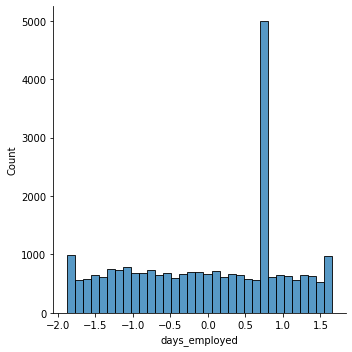

In [21]:
import seaborn as sns

sns.displot(train_cp.days_employed)

## Modeling

In [20]:
## X 인자 크기가 동일한지 확인
print(train_cp.drop(columns = ['credit','index']).shape) # y 빼기
print(test_cp.drop(columns = ['index']).shape) 

(26457, 53)
(10000, 53)


In [21]:
# 혹시나 컬럼 순서가 안맞는게 있는지 획인(0이어야 정상)
sum(train_cp.drop(columns = ['credit','index']).columns != test_cp.drop(columns = ['index']).columns)

0

In [22]:
X_train = train_cp.drop(columns = ['credit','index']).values
y_train = train_cp.credit.astype(int).astype(str).values

In [23]:
X_test = test_cp.drop(columns = ['index']).values

In [24]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [25]:
%%time

clf = lgb.LGBMClassifier()
param_grid = {
    'num_leaves': [70, 100, 300],
    'learning_rate': [0.1, 0.05],
    'max_depth' : [7,10],
    'n_estimators' : [500, 700],
    'colsample_bytree' : [0.3, 0.7, 1.0]
}
gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, verbose = 5, scoring = "accuracy")
lgb_model = gsearch.fit(X_train, y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70, score=0.704, total=   4.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70, score=0.711, total=   4.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70, score=0.703, total=   3.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70, score=0.707, total=   4.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=70, score=0.702, total=   4.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100, score=0.704, total=   3.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100, score=0.711, total=   4.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100, score=0.703, total=   4.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100, score=0.707, total=   4.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=100, score=0.702, total=   4.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70

[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=70, score=0.702, total=  16.0s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=70 
[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=70, score=0.696, total=  14.5s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100, score=0.700, total=  13.8s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100, score=0.709, total=  13.8s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100, score=0.697, total=  14.0s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100 
[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, num_leaves=100, score=0.702, total=  17.1s
[CV] learning_rate=0.1, max_depth=7, n_esti

[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70, score=0.702, total=   6.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70, score=0.698, total=   6.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70, score=0.704, total=   5.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=70, score=0.702, total=   6.2s
[CV] learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=100, score=0.700, total=   5.7s
[CV] learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=5, n_estimators=700, num_leaves=100, score=0.702, total=   5.8s
[CV] learning_rate=0.05, max_depth=5, n_estimat

[CV]  learning_rate=0.05, max_depth=7, n_estimators=1000, num_leaves=100, score=0.702, total=  13.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70, score=0.710, total=  10.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70, score=0.714, total=   8.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70, score=0.709, total=   7.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70, score=0.712, total=   9.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=500, num_leaves=70, score=0.709, total=   8.7s
[CV] learning_rate=0.05, max_depth=10, 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 31.8min finished


{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 70} 0.7108137732925124
Wall time: 31min 56s


In [27]:
lgb_model.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=70, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
lgbm = lgb.LGBMClassifier(
    **lgb_model.best_params_,
    colsample_bytree = 0.3
)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict_proba(X_test)

In [38]:
%%time
from sklearn.model_selection import cross_val_score

cross_val_score(lgbm, X_train, y_train, scoring = 'accuracy', cv = 5).mean()

Wall time: 43.4 s


0.7131567539067118

In [40]:
y_pred_df = pd.concat([test_cp['index'], pd.DataFrame(lgbm.predict_proba(X_test))], axis = 1)

In [41]:
y_pred_df

,index,0,1,2
0,26457,0.291753,0.252954,0.455293
1,26458,0.226470,0.207383,0.566146
2,26459,0.098913,0.096507,0.804580
3,26460,0.047128,0.105640,0.847232
4,26461,0.066560,0.179647,0.753793
...,...,...,...,...
9995,36452,0.142904,0.384809,0.472287
9996,36453,0.369840,0.221904,0.408256
9997,36454,0.074552,0.089568,0.835881
9998,36455,0.136223,0.205298,0.658479


In [42]:
from collections import Counter
Counter(lgbm.predict(X_test))

Counter({'2': 8609, '0': 292, '1': 1099})

In [29]:
from collections import Counter
Counter(lgbm.predict(X_test))

Counter({'0': 381, '2': 8389, '1': 1230})

In [43]:
y_pred_df.to_csv('./data/sub.csv', index = False)

## 개선방안
- https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent
- 날짜변수 분포 보고전처리하기
- 직업코드 전처리하기
- 중복데이터 제거

C:\Users\AgileSoda\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income_total', ylabel='Density'>

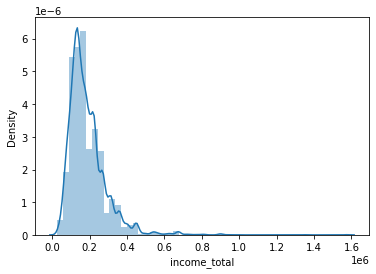

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(train_cp.income_total)

C:\Users\AgileSoda\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

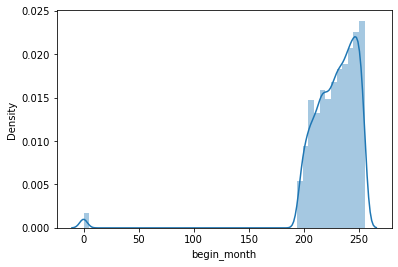

In [53]:
sns.distplot(train_cp.begin_month)

C:\Users\AgileSoda\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_employed', ylabel='Density'>

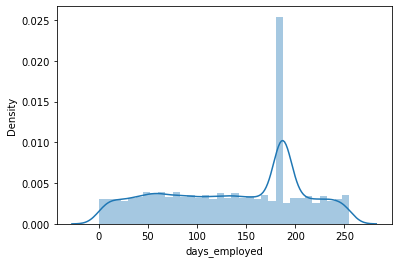

In [54]:
sns.distplot(train_cp.days_employed)

C:\Users\AgileSoda\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_birth', ylabel='Density'>

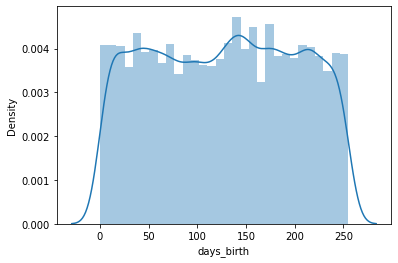

In [55]:
sns.distplot(train_cp.days_birth)